In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def custom_read_csv(filename):
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

In [3]:
national_price = custom_read_csv('national.csv')
state_price = custom_read_csv('state.csv')
state_price = state_price.drop('Unnamed: 10', axis=1)
city_price = custom_read_csv('city.csv')
price = pd.concat([national_price, state_price, city_price])

In [7]:
spot = custom_read_csv('spot.csv').drop('Unnamed: 3', axis=1)
supply = custom_read_csv('productsupplied.csv')
stocks = custom_read_csv('stocks.csv')
predictors = pd.concat([spot, supply, stocks])

In [23]:
yearly_price = price.national.groupby(price.index.year).median()

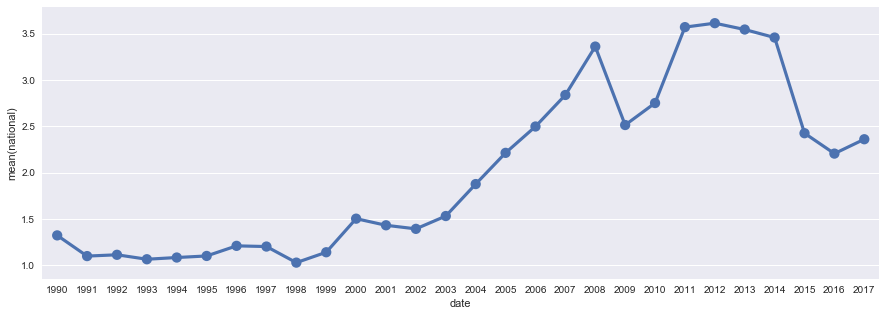

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(yearly_price.index.astype(int), yearly_price, ax=ax)